In [6]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
#from tensorflow.keras import layers
#need tensorflow gpu 

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)



Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1733513808.596353    5674 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2613 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


In [19]:
from Exctract_features import *
pwd = "./513_distribute" 
label = {'H': 0, 'E': 1, 'C': 2}

df1 = create_dataset(pwd, 'ohe', True) 
print("Done")# Depuis le script Exctract_features
#display(df1)

Precessing files ...


Processing files: 100%|██████████| 513/513 [00:01<00:00, 289.13it/s]


Encoding ...
OneHot Encoding ...


Processing files: 100%|██████████| 77963/77963 [00:03<00:00, 22318.99it/s]


Dataframe creation...
Resampling ...
Processing... Please wait.
Resampling complete!
Done


/home/jhodi/Documents/GitHub/MLP_avec_Taveau/Exctract_features.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_df['DSSP'] = y_resampled


In [3]:
x = df1.drop('DSSP', axis=1)
y = df1['DSSP']
display(x)
display(y)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259
RES,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CDAFVGTWKLVSS,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
DAFVGTWKLVSSE,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
AFVGTWKLVSSEN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FVGTWKLVSSENF,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
VGTWKLVSSENFD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTFPGHSALMKGT,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
TFPGHSALMKGTL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
FPGHSALMKGTLT,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


RES
CDAFVGTWKLVSS    2
DAFVGTWKLVSSE    2
AFVGTWKLVSSEN    2
FVGTWKLVSSENF    2
VGTWKLVSSENFD    2
                ..
CTFPGHSALMKGT    2
TFPGHSALMKGTL    2
FPGHSALMKGTLT    2
PGHSALMKGTLTL    2
GHSALMKGTLTLK    2
Name: DSSP, Length: 77963, dtype: int64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)
display(y_train_one_hot)

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='min')

In [6]:
model = keras.Sequential([
    keras.layers.Dense(500, activation='relu'),  
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dense(3, activation='softmax')                   
])

opt = keras.optimizers.Adam(learning_rate=0.008)
#3 sortit couche softmax pour avoir les proba de chaque class 
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
history = model.fit(X_train, y_train_one_hot, epochs=3, batch_size=32, validation_data=(X_test, y_test_one_hot),callbacks=early_stopping)

Epoch 1/3
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5632 - loss: 0.9376 - val_accuracy: 0.6057 - val_loss: 0.8789
Epoch 2/3
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6135 - loss: 0.8603 - val_accuracy: 0.6085 - val_loss: 0.8619
Epoch 3/3
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6419 - loss: 0.8063 - val_accuracy: 0.6117 - val_loss: 0.8741


In [30]:
# Function to plot training and validation loss
def plot_loss(history, title="Loss Curve"):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

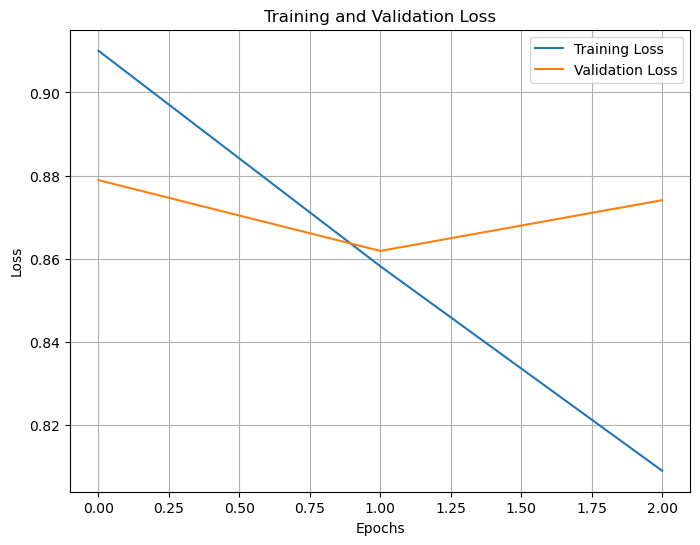

In [9]:
# Call the plot_loss function with the captured history
plot_loss(history, title="Training and Validation Loss")

In [10]:
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy*100:.4f}')

488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6044 - loss: 0.8827
Loss: 0.8741, Accuracy: 61.1685


488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


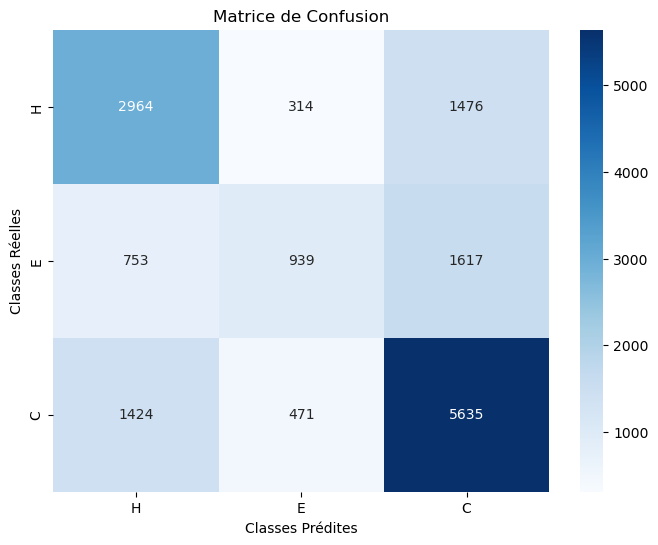

In [11]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédite avec la plus haute probabilité

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['H', 'E', 'C'], yticklabels=['H', 'E', 'C'])
plt.title('Matrice de Confusion')
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.show()

In [20]:
from Exctract_features import *
pwd = "./513_distribute" 
label = {'H': 0, 'E': 1, 'C': 2}

df2 = create_dataset(pwd, 'freq',True) # Depuis le script Exctract_features
display(df2)

Precessing files ...


Processing files: 100%|██████████| 513/513 [00:01<00:00, 257.94it/s]


Encoding ...
Frequences calculation ...


Processing files: 100%|██████████| 77963/77963 [00:00<00:00, 109973.22it/s]


Dataframe creation...
Resampling ...
Processing... Please wait.
Resampling complete!


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,DSSP
0,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.000000,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846,2
1,0.076923,0.000000,0.000000,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846,2
2,0.076923,0.000000,0.076923,0.000000,0.000000,0.0,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846,2
3,0.000000,0.000000,0.076923,0.000000,0.000000,0.0,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.153846,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846,2
4,0.000000,0.000000,0.076923,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111433,0.076923,0.000000,0.076923,0.076923,0.076923,0.0,0.032670,0.230769,0.000000,0.000000,0.076923,0.000000,0.0,0.000000,0.000000,0.076923,0.121176,0.076923,0.000000,0.076923,1
111434,0.025690,0.000000,0.000000,0.076923,0.000000,0.0,0.076923,0.000000,0.000000,0.000000,0.205079,0.000000,0.0,0.025690,0.076923,0.000000,0.128156,0.025690,0.051233,0.307692,1
111435,0.097017,0.000000,0.000000,0.020094,0.056829,0.0,0.076923,0.153846,0.000000,0.056829,0.230769,0.000000,0.0,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.153846,1
111436,0.076923,0.153846,0.076923,0.000190,0.000000,0.0,0.000000,0.076733,0.076923,0.000000,0.076923,0.000000,0.0,0.076923,0.000000,0.076923,0.154036,0.000000,0.000000,0.153656,1


In [13]:
x = df2.drop('DSSP', axis=1)
y = df2['DSSP']
display(x)
display(y)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
RES,,,,,,,,,,,,,,,,,,,,
CDAFVGTWKLVSS,0.076923,0.0,0.000000,0.076923,0.076923,0.0,0.000000,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.076923,0.000000,0.153846,0.076923,0.076923,0.0,0.153846
DAFVGTWKLVSSE,0.076923,0.0,0.000000,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.076923,0.000000,0.153846,0.076923,0.076923,0.0,0.153846
AFVGTWKLVSSEN,0.076923,0.0,0.076923,0.000000,0.000000,0.0,0.076923,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.076923,0.000000,0.153846,0.076923,0.076923,0.0,0.153846
FVGTWKLVSSENF,0.000000,0.0,0.076923,0.000000,0.000000,0.0,0.076923,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.153846,0.000000,0.153846,0.076923,0.076923,0.0,0.153846
VGTWKLVSSENFD,0.000000,0.0,0.076923,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.076923,0.000000,0.153846,0.076923,0.076923,0.0,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTFPGHSALMKGT,0.076923,0.0,0.000000,0.000000,0.076923,0.0,0.000000,0.153846,0.076923,0.0,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.153846,0.000000,0.0,0.000000
TFPGHSALMKGTL,0.076923,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.153846,0.076923,0.0,0.153846,0.076923,0.076923,0.076923,0.076923,0.076923,0.153846,0.000000,0.0,0.000000
FPGHSALMKGTLT,0.076923,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.153846,0.076923,0.0,0.153846,0.076923,0.076923,0.076923,0.076923,0.076923,0.153846,0.000000,0.0,0.000000


RES
CDAFVGTWKLVSS    2
DAFVGTWKLVSSE    2
AFVGTWKLVSSEN    2
FVGTWKLVSSENF    2
VGTWKLVSSENFD    2
                ..
CTFPGHSALMKGT    2
TFPGHSALMKGTL    2
FPGHSALMKGTLT    2
PGHSALMKGTLTL    2
GHSALMKGTLTLK    2
Name: DSSP, Length: 77963, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)
display(y_train_one_hot)

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [15]:
model2 = keras.Sequential([
    keras.layers.Dense(1000, activation='relu'), 
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(500, activation='relu'), 
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dense(3, activation='softmax')                   
])

#3 sortit couche softmax pour avoir les proba de chaque class 
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [16]:
history2 = model2.fit(X_train, y_train_one_hot, 
                    epochs=40, 
                    batch_size=32, 
                    validation_data=(X_test, y_test_one_hot), 
                    callbacks=early_stopping)


Epoch 1/40
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.5226 - loss: 0.9884 - val_accuracy: 0.5449 - val_loss: 0.9655
Epoch 2/40
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.5331 - loss: 0.9712 - val_accuracy: 0.5402 - val_loss: 0.9609
Epoch 3/40
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.5389 - loss: 0.9620 - val_accuracy: 0.5465 - val_loss: 0.9506
Epoch 4/40
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.5436 - loss: 0.9513 - val_accuracy: 0.5465 - val_loss: 0.9502
Epoch 5/40
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.5439 - loss: 0.9455 - val_accuracy: 0.5522 - val_loss: 0.9398
Epoch 6/40
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5559 - loss: 0.9269 - val_accuracy: 0.5556 - val_loss: 0.9354
Epoch 7/40
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.5637 - loss: 0.9091 - val_accuracy: 0.5594 - val_loss: 0.9309
Epoch 8/40
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5809 -

In [8]:
# Call the plot_loss function with the captured history
plot_loss(history2, title="Training and Validation Loss")

NameError: name 'plot_loss' is not defined

In [18]:
loss, accuracy = model2.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy*100:.4f}')

488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6064 - loss: 0.9309
Loss: 0.9183, Accuracy: 61.2903


488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


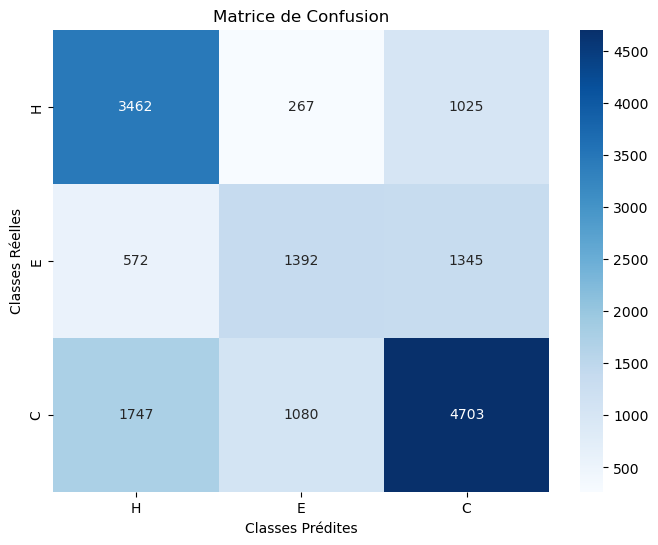

In [19]:
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédite avec la plus haute probabilité

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['H', 'E', 'C'], yticklabels=['H', 'E', 'C'])
plt.title('Matrice de Confusion')
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.show()

In [21]:
print(df1.shape, df2.shape)

(111438, 261) (111438, 21)


In [22]:
combine_df = pd.concat([df1, df2.drop(columns = 'DSSP')], axis = 1)
combine_df.shape

(111438, 281)

In [25]:
x = combine_df.drop('DSSP', axis=1)
y = combine_df['DSSP']
display(x)
display(y)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.000000,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.076923,0.000000,0.000000,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.076923,0.000000,0.076923,0.000000,0.000000,0.0,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.000000,0.076923,0.000000,0.000000,0.0,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.153846,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.076923,0.076923,0.000000,0.0,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.000000,0.153846,0.076923,0.076923,0.000000,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111433,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.076923,0.000000,0.076923,0.076923,0.076923,0.0,0.032670,0.230769,0.000000,0.000000,0.076923,0.000000,0.0,0.000000,0.000000,0.076923,0.121176,0.076923,0.000000,0.076923
111434,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.025690,0.000000,0.000000,0.076923,0.000000,0.0,0.076923,0.000000,0.000000,0.000000,0.205079,0.000000,0.0,0.025690,0.076923,0.000000,0.128156,0.025690,0.051233,0.307692
111435,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.097017,0.000000,0.000000,0.020094,0.056829,0.0,0.076923,0.153846,0.000000,0.056829,0.230769,0.000000,0.0,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.153846
111436,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.076923,0.153846,0.076923,0.000190,0.000000,0.0,0.000000,0.076733,0.076923,0.000000,0.076923,0.000000,0.0,0.076923,0.000000,0.076923,0.154036,0.000000,0.000000,0.153656


0         2
1         2
2         2
3         2
4         2
         ..
111433    1
111434    1
111435    1
111436    1
111437    1
Name: DSSP, Length: 111438, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train_comb = to_categorical(y_train, num_classes=3)
y_test_comb = to_categorical(y_test, num_classes=3)
display(y_train_comb)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [27]:
model3 = keras.Sequential([
    keras.layers.Dense(1000, activation='relu'), 
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(500, activation='relu'), 
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dense(3, activation='softmax')                   
])

#3 sortit couche softmax pour avoir les proba de chaque class 
opt = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history3 = model3.fit(X_train, y_train_comb, 
                    epochs=40, 
                    batch_size=32, 
                    validation_data=(X_test, y_test_comb), 
                    callbacks=early_stopping)


Epoch 1/40
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.6046 - loss: 0.8413 - val_accuracy: 0.6596 - val_loss: 0.7471
Epoch 2/40
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.6888 - loss: 0.7010 - val_accuracy: 0.6781 - val_loss: 0.7219
Epoch 3/40
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.7533 - loss: 0.5792 - val_accuracy: 0.6726 - val_loss: 0.7472
Epoch 4/40
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.8230 - loss: 0.4287 - val_accuracy: 0.6603 - val_loss: 0.8291
Epoch 5/40
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.8866 - loss: 0.2877 - val_accuracy: 0.6511 - val_loss: 1.0548
Epoch 6/40
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9333 - loss: 0.1767 - val_accuracy: 0.6367 - val_loss: 1.2964
Epoch 7/40
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.9555 - loss: 0.1204 - val_accuracy: 0.6438 - val_loss: 1.6776
Epoch 8/40
2786/2786 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.9681 -

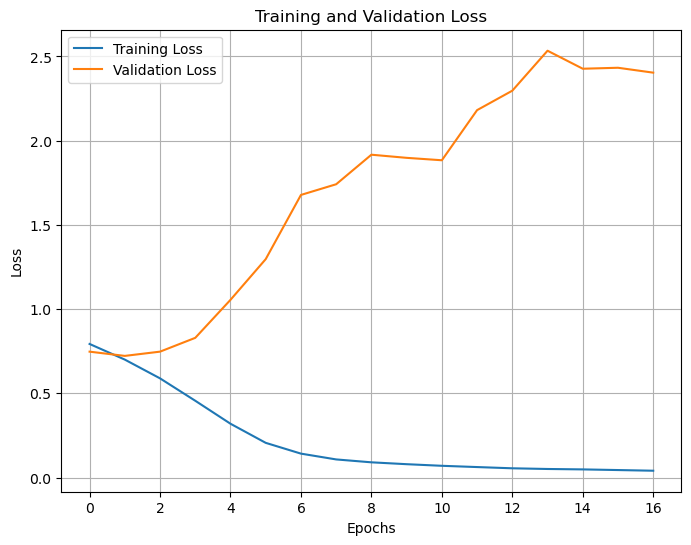

In [31]:
# Call the plot_loss function with the captured history
plot_loss(history3, title="Training and Validation Loss")

697/697 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step


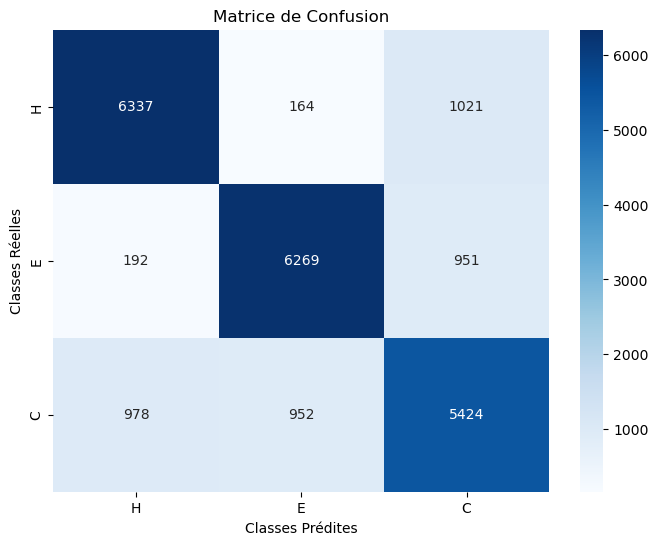

In [29]:
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédite avec la plus haute probabilité

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['H', 'E', 'C'], yticklabels=['H', 'E', 'C'])
plt.title('Matrice de Confusion')
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.show()